# Relatório EP1 - Computação Paralela e Concorrente

**Alunos**: 
- Erick Rodrigues de Santana, NUSP: 11222008
- Francisco Eugênio Wernke, NUSP: 11221870
- Thiago Guerrero Balera, NUSP: 11275297
- Vinicius Pereira Ximenes Frota, NUSP: 11221967

**Professor**: Alfredo Goldman

**Monitores**: Elisa Silva e Luciana Marques

O relatório a seguir foi elaborado com base nas instruções do EP1 da Matéria MAC0219 - Computação Paralela e Concorrente. Vamos explicitar aqui, somente os resultados do experimento realizado e demonstrar como a paralelização de algoritmos otimiza o tempo em computadores multicore.

### Executando o programa
Para executar o programa mandelbrot nas versões paralelizáveis (OpenMP e Pthreads), adicionamos um argumento extra para definir o número de threads a serem criadas. Execute com o seguinte formato:
```bash
./mandelbrot_pth c_x_min c_x_max c_y_min c_y_max image_size num_threads
./mandelbrot_omp c_x_min c_x_max c_y_min c_y_max image_size num_threads
```

In [2]:
# Bibliotecas importadas
using CSV
using DataFrames
using Plots

# Leitura de dados CSV
csv = CSV.read("../measurements/data.csv", DataFrame)
print(csv)

5200×6 DataFrame
  Row │ tipo    tamanho  threads  tempo           io         figura             
      │ String  Int64    Int64    Float64         Float64    String             
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ seq          16        1       0.056505     48.7926  full
    2 │ seq          16        1       0.152588     76.9372  full
    3 │ seq          16        1       0.132561     64.899   full
    4 │ seq          16        1       0.152349     53.5328  full
    5 │ seq          16        1       0.153542     53.5104  full
    6 │ seq          16        1       0.140667     53.6222  full
    7 │ seq          16        1       0.132561     53.7527  full
    8 │ seq          16        1       0.153303     53.5026  full
    9 │ seq          16        1       0.153065     53.551   full
   10 │ seq          16        1       0.152588     53.5407  full
   11 │ seq          16        1       0.862122     50.4673  seahorseValley
   1

 1707 │ pth          64        8      54.3954        0.0     elephantValley
 1708 │ pth          64        8      54.6594        0.0     elephantValley
 1709 │ pth          64        8     254.951         0.0     elephantValley
 1710 │ pth          64        8     646.722         0.0     elephantValley
 1711 │ pth          64        8     176.789         0.0     tripleSpiralValley
 1712 │ pth          64        8      55.7959        0.0     tripleSpiralValley
 1713 │ pth          64        8      54.5325        0.0     tripleSpiralValley
 1714 │ pth          64        8      65.5963        0.0     tripleSpiralValley
 1715 │ pth          64        8      65.4817        0.0     tripleSpiralValley
 1716 │ pth          64        8      66.0405        0.0     tripleSpiralValley
 1717 │ pth          64        8      65.5391        0.0     tripleSpiralValley
 1718 │ pth          64        8      65.8133        0.0     tripleSpiralValley
 1719 │ pth          64        8      54.4825        0.0

 2564 │ pth         256       32     201.05          0.0     full
 2565 │ pth         256       32     111.618         0.0     full
 2566 │ pth         256       32     117.887         0.0     full
 2567 │ pth         256       32     253.824         0.0     full
 2568 │ pth         256       32     247.889         0.0     full
 2569 │ pth         256       32     210.964         0.0     full
 2570 │ pth         256       32     713.202         0.0     full
 2571 │ pth         256       32     225.63          0.0     seahorseValley
 2572 │ pth         256       32      87.1058        0.0     seahorseValley
 2573 │ pth         256       32      99.9057        0.0     seahorseValley
 2574 │ pth         256       32      87.2803        0.0     seahorseValley
 2575 │ pth         256       32      89.1211        0.0     seahorseValley
 2576 │ pth         256       32      98.3105        0.0     seahorseValley
 2577 │ pth         256       32      87.2264        0.0     seahorseValley
 2578 

 3421 │ omp         512        2     329.893         0.0     elephantValley
 3422 │ omp         512        2     498.056         0.0     elephantValley
 3423 │ omp         512        2     598.972         0.0     elephantValley
 3424 │ omp         512        2     366.507         0.0     elephantValley
 3425 │ omp         512        2     402.035         0.0     elephantValley
 3426 │ omp         512        2     329.988         0.0     elephantValley
 3427 │ omp         512        2     479.778         0.0     elephantValley
 3428 │ omp         512        2     417.395         0.0     elephantValley
 3429 │ omp         512        2     374.69          0.0     elephantValley
 3430 │ omp         512        2     724.296         0.0     elephantValley
 3431 │ omp         512        2     439.846         0.0     tripleSpiralValley
 3432 │ omp         512        2     410.143         0.0     tripleSpiralValley
 3433 │ omp         512        2     396.24          0.0     tripleSpiralValley


 4277 │ omp        1024        8     758.659         0.0     tripleSpiralValley
 4278 │ omp        1024        8     613.03          0.0     tripleSpiralValley
 4279 │ omp        1024        8    1134.75          0.0     tripleSpiralValley
 4280 │ omp        1024        8     552.288         0.0     tripleSpiralValley
 4281 │ omp        2048        8    1046.62          0.0     full
 4282 │ omp        2048        8     971.473         0.0     full
 4283 │ omp        2048        8    1627.29          0.0     full
 4284 │ omp        2048        8     901.132         0.0     full
 4285 │ omp        2048        8     929.423         0.0     full
 4286 │ omp        2048        8    1030.17          0.0     full
 4287 │ omp        2048        8    1713.9           0.0     full
 4288 │ omp        2048        8    1045.83          0.0     full
 4289 │ omp        2048        8    1230.05          0.0     full
 4290 │ omp        2048        8     943.872         0.0     full
 4291 │ omp        2

### Organização dos dados

Para agrupar os dados coletados usamos dicionários, a estrutura pode ser entendida assim:
```js
{
    seq: {
        full: {
            Tamanho de entrada(2^4...2^13): Pair<Média, Intervalo de confiança>
        },
        seahorseValley: ... ,
        elephantValley: ... ,
        tripleSpiralValley: ...
    },
    pth: {
        full: {
            Tamanho de entrada(2^4...2^13): [
                2^0 threads: Pair<Média, Intervalo de confiança>,
                2^1 threads: Pair<Média, Intervalo de confiança>,
                ... ,
                2^5 threads: Pair<Média, Intervalo de confiança>
            ]
        },
        seahorseValley: ... ,
        elephantValley: ... ,
        tripleSpiralValley: ...
    },
    omp: ...Igual a pthread
}
```

In [3]:
data = Dict();
data["seq"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());
data["seqio"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());
data["pth"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());
data["omp"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());

keys = ["full", "seahorseValley", "elephantValley", "tripleSpiralValley"];
for i in 4:13
     for t in keys
         pair = 1 => 0;
         data["seq"][t][2^i] = pair;
         data["seqio"][t][2^i] = pair;
         data["pth"][t][2^i] = Pair{Float64, Float64}[];
         data["omp"][t][2^i] = Pair{Float64, Float64}[];
     end
end

### Intervalo de confiança

Como o intervalo de confiança é simétrico em torno da média, só retornamos os limiares. Para 95% de nível de confiança e 9 graus de liberdade, obtemos pela tabela da t-student o valor 2.2622 para z.


In [4]:
function confidence_interval(vector, mean)
    z = 2.2622;
    n = length(vector);
    sigma = 0;
    for i in 1:n
        sigma += (vector[i] - mean)^2;
    end
    sigma /= n-1;
    sigma = sqrt(sigma);
    return z * sigma/sqrt(n);
end;

In [5]:
size = nrow(csv)

for i in 11:10:size+1
    tipo = csv.tipo[i-1];
    figura = csv.figura[i-1];
    tamanho = csv.tamanho[i-1];
    threads = csv.threads[i-1];
    if (tipo == "seq")
        vector = vcat(csv.tempo[i-10:i-1], csv.io[i-10:i-1]);
        sum = reduce(+, vector);
        pair = sum/10 => confidence_interval(vector, sum/10);
        data["seqio"][figura][tamanho] = pair;

        sum  = reduce(+, csv.tempo[i-10:i-1]);
        pair = sum/10 => confidence_interval(csv.tempo[i-10:i-1], sum/10);
        data[tipo][figura][tamanho] = pair;
    else
        sum  = reduce(+, csv.tempo[i-10:i-1]);
        pair = sum/10 => confidence_interval(csv.tempo[i-10:i-1], sum/10);
        push!(data[tipo][figura][tamanho], pair);
    end
end

In [6]:
x = [];
for i in 4:13
    append!(x, 2^i);
end

In [63]:
function plot_by_number_of_threads(threads)
    id = convert(Int64, log2(threads) + 1);
    for tipo in keys
        plot_seq = [];
        interval_seq = [];
        plot_pth = [];
        interval_pth = [];
        plot_omp = [];
        interval_omp = [];
        for i in 4:13
            append!(plot_seq, data["seq"][tipo][2^i].first);
            append!(plot_pth, data["pth"][tipo][2^i][id].first);
            append!(plot_omp, data["omp"][tipo][2^i][id].first);

            append!(interval_seq, data["seq"][tipo][2^i].second);
            append!(interval_pth, data["pth"][tipo][2^i][id].second);
            append!(interval_omp, data["omp"][tipo][2^i][id].second);
        end
        title = string(threads) * " Thread(s) - " * tipo;
        #g = plot(x, plot_seq, title=title, label= "seq", lw = 3, legend=:bottomright)
        g = plot(x, plot_seq, title=title, label= "seq", lw = 3, legend=:bottomright, 
            ribbon = (-10 .* ones(10), 10 .* ones(10)))
        
        
#         g = plot!(x, plot_pth,label="pthreads", lw = 3)
#         g = plot!(pred.x, pr.prediction, label="model", lw=3, 
#             ribbon = (pr.prediction .- pr.lower, pr.upper .- pr.prediction))
        
#         g = plot!(x, plot_omp,label="OMP", lw = 3)
#         g = plot!(pred.x, pr.prediction, label="model", lw=3, 
#             ribbon = (pr.prediction .- pr.lower, pr.upper .- pr.prediction))
        
        xlabel!("Tamanho da entrada")
        ylabel!("Tempo(ms)")
        display(g)
#         display(plot_seq .- interval_seq)
#         display(plot_seq .+ interval_seq)
        display(plot_seq)
        display(interval_seq)
    end
end;


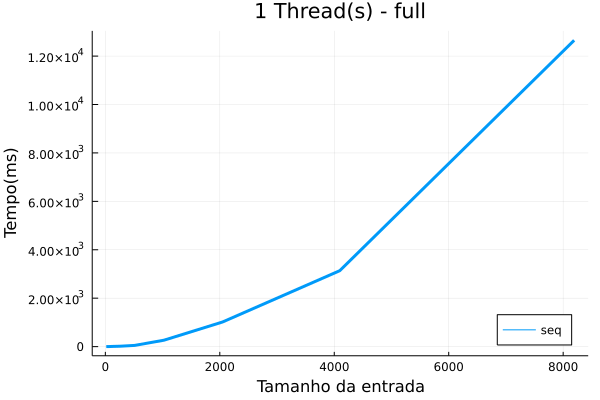

10-element Vector{Any}:
     0.1379729
     0.47912599999999994
     1.9215108
     7.873630499999999
    15.917945000000003
    49.244785199999995
   264.52813150000003
  1016.7176247000001
  3135.6601477
 12651.983571100001

10-element Vector{Any}:
   0.021384018586178152
   0.10459334516662895
   0.33069290043468363
   1.2098377559102849
   1.0047110251569522
   0.2923236147376352
  62.14611976703283
 114.62006551602894
  15.629449201008324
  86.15727363049183

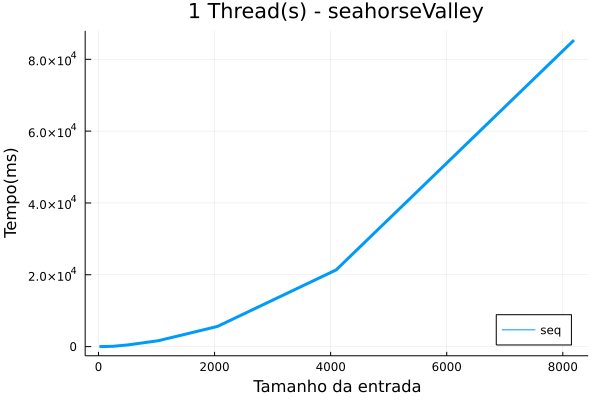

10-element Vector{Any}:
     0.8259535
     3.4949542
    11.351895500000001
    29.911065200000003
    97.3278523
   483.4656477999999
  1622.3807333999998
  5609.428358
 21370.0461627
 85345.45774449999

10-element Vector{Any}:
   0.11424475870087716
   0.12086300674064435
   1.9818981853944146
   5.011205071117834
  22.951157959853727
  98.15070711557748
 138.6378623618419
 175.36124005092216
  35.60651301980997
  28.727154454214887

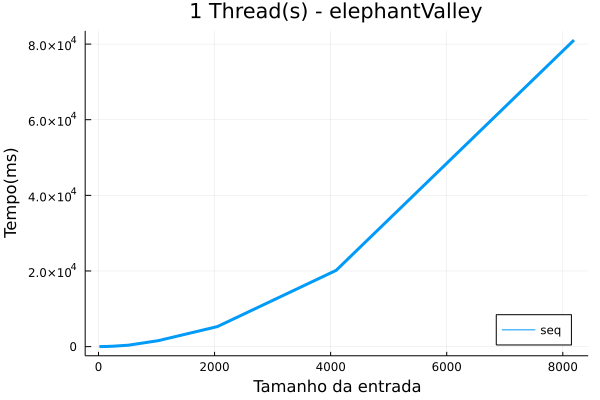

10-element Vector{Any}:
     0.8501290000000001
     2.9466390000000002
    11.886095999999998
    25.9531261
   111.10925669999999
   368.7791108
  1557.0066689999999
  5291.341614700001
 20178.568506300006
 81053.31130029999

10-element Vector{Any}:
   0.03899388591905703
   0.6289723347674252
   1.7411686585780457
   1.7849136071466987
  28.100432994149923
  74.36367462276334
  83.35195856680826
 140.83588106328727
  10.844339422590533
 516.516743126719

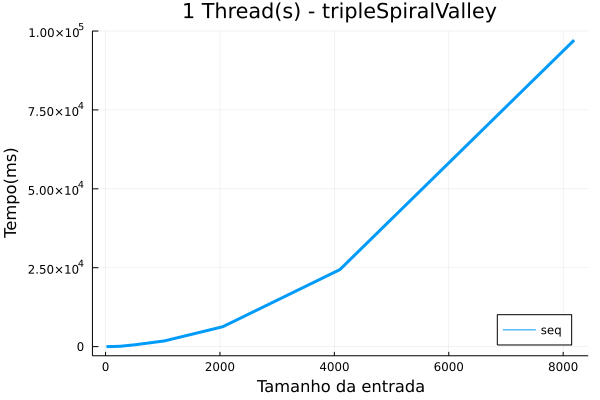

10-element Vector{Any}:
     0.9952307000000001
     3.945040699999999
    13.8485432
    30.023574900000007
   102.4855613
   573.9488124
  1786.6112710000002
  6294.398069299999
 24393.079995900003
 97120.4322576

10-element Vector{Any}:
   0.0424846095187096
   0.13296147965030589
   0.8947254709784537
   1.691563695122185
  10.278017793365773
  96.10748221908864
 137.68172365250012
 166.30727224211202
  48.27938979795244
  34.98234942550037

In [64]:
plot_by_number_of_threads(2^0)

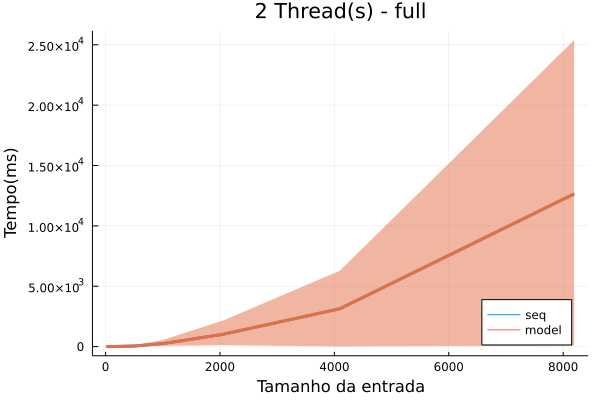

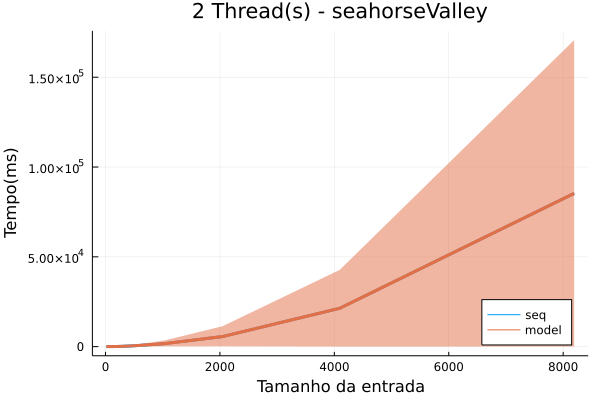

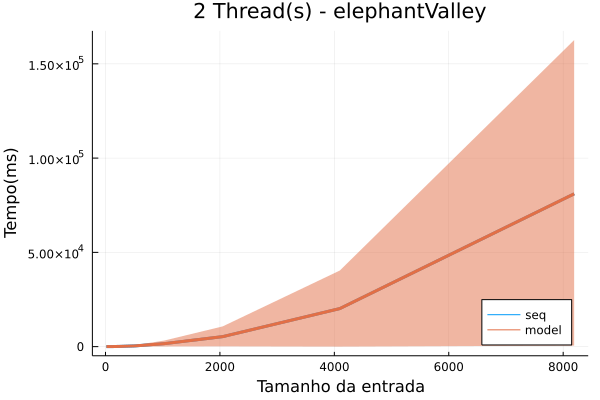

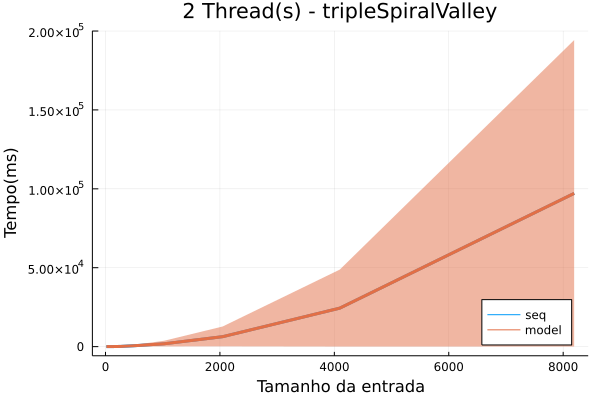

In [9]:
plot_by_number_of_threads(2^1)

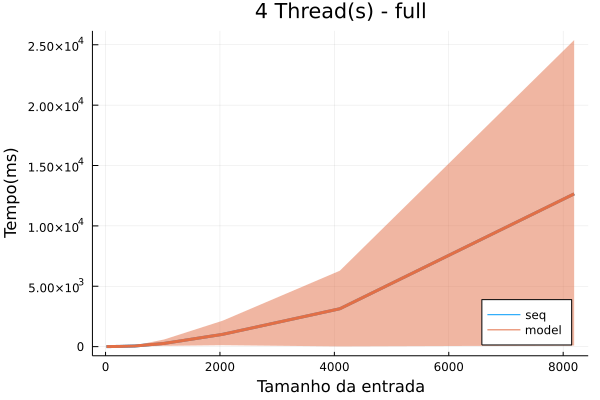

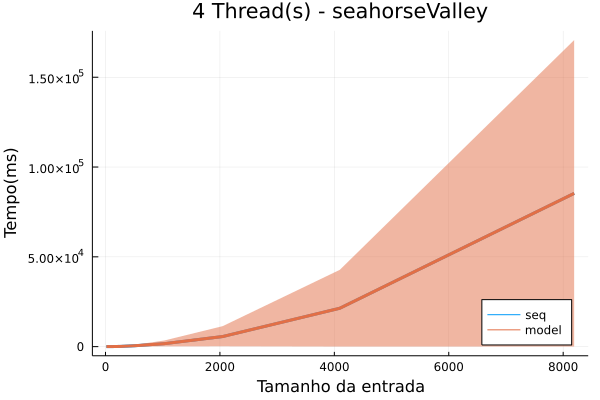

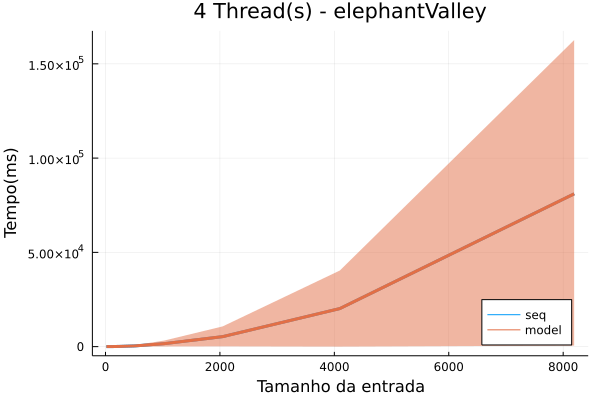

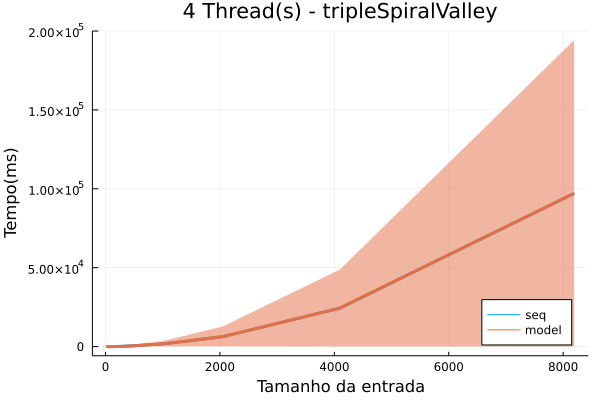

In [10]:
plot_by_number_of_threads(2^2)

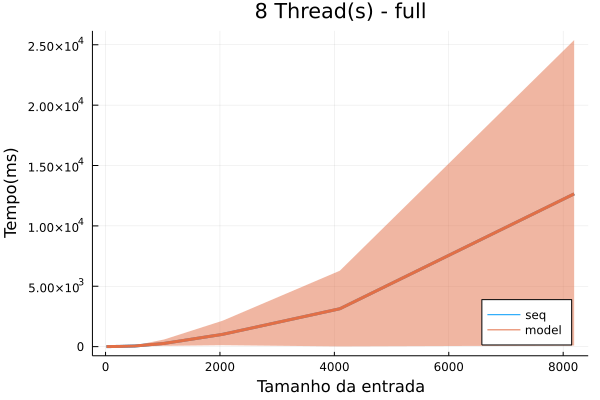

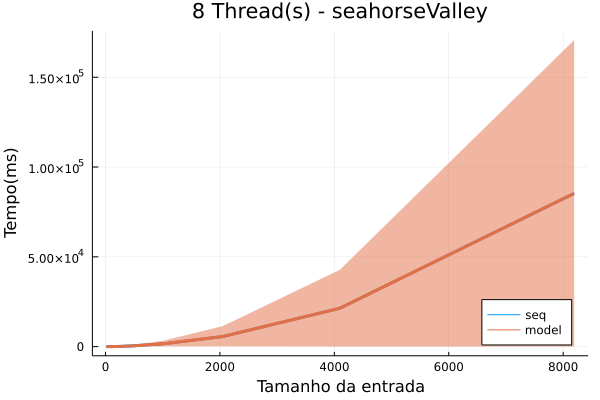

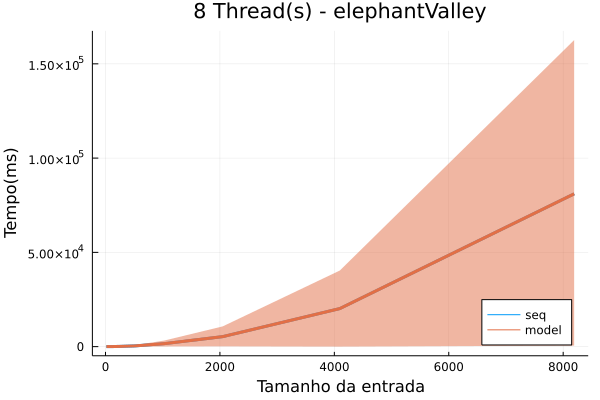

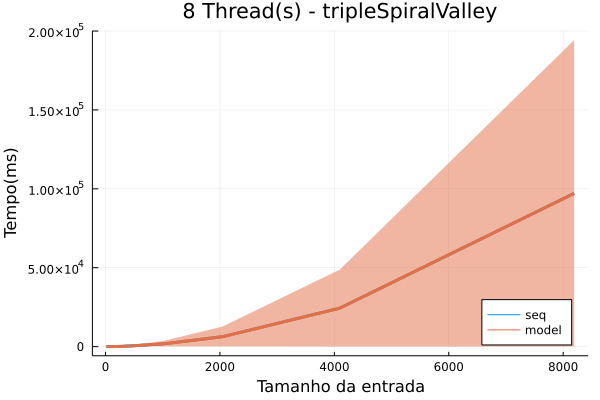

In [11]:
plot_by_number_of_threads(2^3)

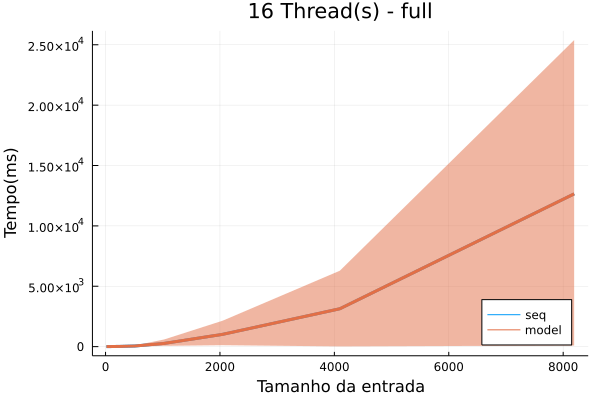

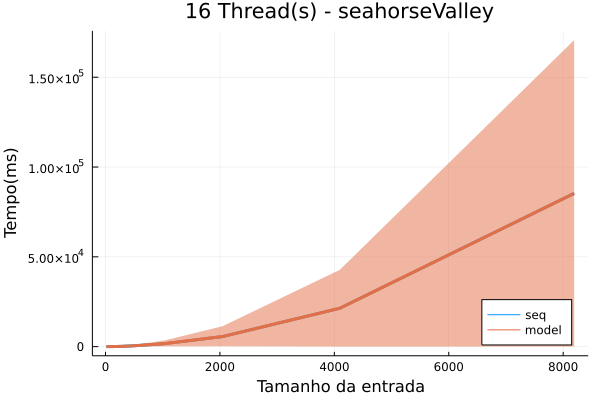

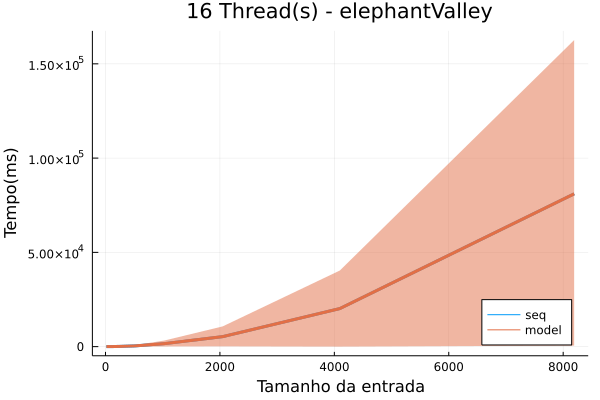

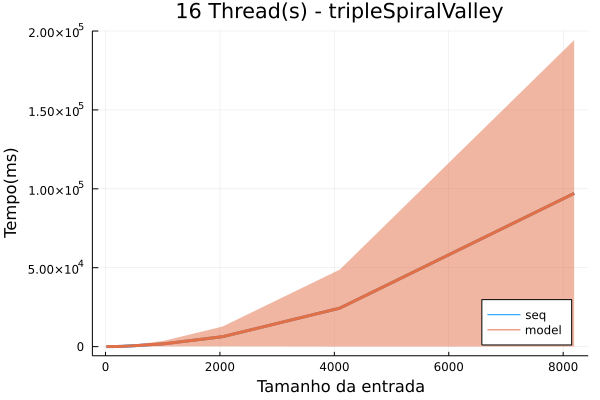

In [12]:
plot_by_number_of_threads(2^4)

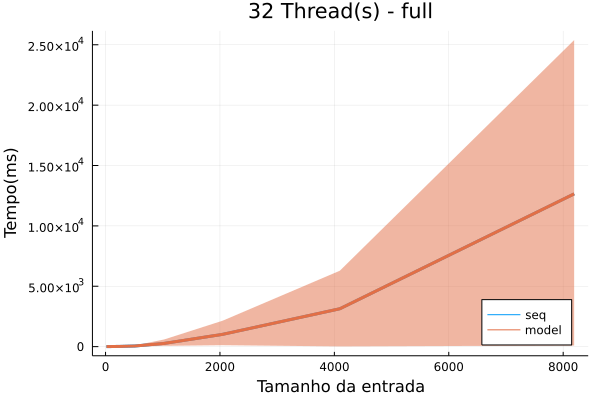

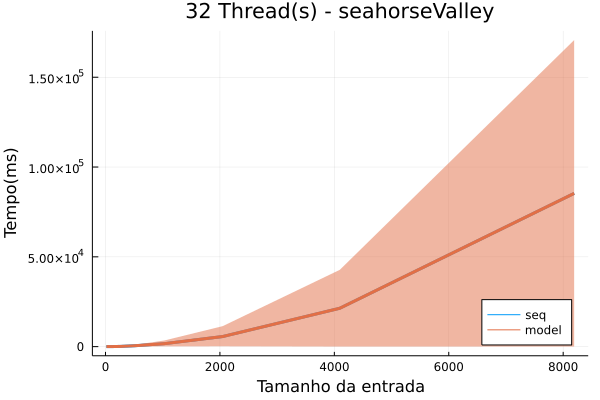

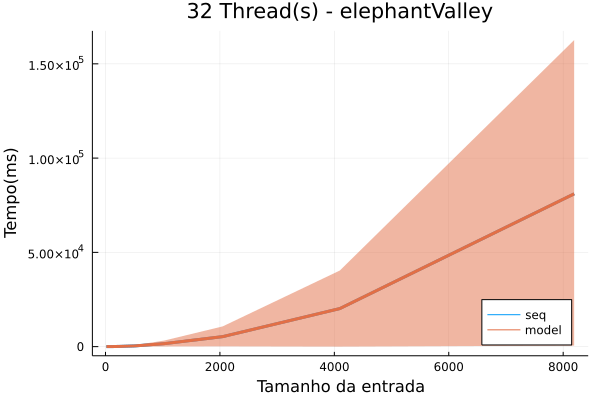

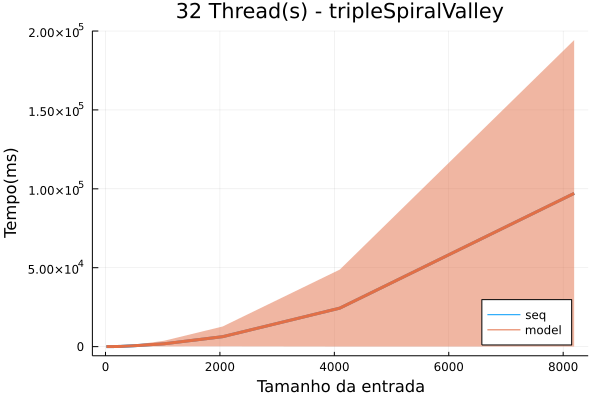

In [13]:
plot_by_number_of_threads(2^5)